<a href="https://colab.research.google.com/github/jamsun9907/Sentiment_analysis_game_review/blob/main/Section_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 4 Project
## Sentiment analysis 

## Data processing

### Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Konlp 사이트 참고
https://konlpy.org/en/v0.6.0/api/konlpy.tag/

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 463 kB/s 
     |████████████████████████████████| 465 kB 67.3 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-12-01 22:07:30--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bi

### Data loading

In [ ]:
## config
from google.colab import files
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from konlpy.tag import Mecab, Kkma, Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
path = '/content/drive/MyDrive/0.Data for analysis/Project/steam.txt'

df = pd.read_csv(path, sep = '\t', header=None, names = ['label', 'reviews'])

df.head(5)

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [ ]:
print('Total reviews : ', len(df))
print('중복 제거 샘플')
df['label'].nunique(), df['reviews'].nunique()

Total reviews :  100000
중복 제거 샘플


(2, 99892)

In [ ]:
# label 비율 확인
sns.countplot(x = 'label', data = df)
plt.xlabel('Label')
plt.title('Number of positive and negetive reviews');

### 전처리

In [ ]:
# 중복제거
df_clean = df.copy()
df.drop_duplicates(subset = 'reviews', inplace = True)

# Null 확인
df_clean.isna().sum() # 없음

label      0
reviews    0
dtype: int64

In [ ]:
# 리뷰 데이터 전처리
label = df_clean['label']
target = pd.DataFrame(df_clean['reviews'])

target.head(5)

,reviews
0,노래가 너무 적음
1,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


**텍스트 데이터 전처리 해줄 함수를 정의**

In [ ]:
def processing(sentence):
    pat = re.compile('[^\w ]')
    sent = re.sub(pat,'', sentence)
    return sent

In [ ]:
# 이모티콘 태깅이 된다면 굳이 전처리할 필요가 없지...
# target = target.apply(lambda x:processing(x))

In [ ]:
# checking
target.head(10)

,reviews
0,노래가 너무 적음
1,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
5,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요^^
6,재미있었습니다.
7,은근 쉽지만 은근 어려운 게임
8,베ㅈ스다 이 개^ㅐ끼들아. 시작할 때 체스판 돌아가는거 5분동안 3번 봤더나 ㅈㄴ ...
9,1시간 40분동안 스트레스 다 풀림 ㄹㅇ


### Tokenize / stopwords / normalize / POS tagging
- 토큰화는 Twitter를 사용한다. (인터넷 텍스트에 강하다는 특징), (Kkma가 시간은 17배 더 오래걸리는데 성능이 그렇게 좋아지는지는 모르겠음) 
- 추후 성능을 비교하는 걸로
- 극성을 가지는 단어는 명사, 동사, 형용사이므로 토큰화에도 이 셋만 포함(책 참고)

**참고** https://needjarvis.tistory.com/691   
https://velog.io/@metterian/%ED%95%9C%EA%B5%AD%EC%96%B4-%ED%98%95%ED%83%9C%EC%86%8C-%EB%B6%84%EC%84%9D%EA%B8%B0POS-%EB%B6%84%EC%84%9D-3%ED%8E%B8.-%ED%98%95%ED%83%9C%EC%86%8C-%EB%B6%84%EC%84%9D%EA%B8%B0-%EB%B9%84%EA%B5%90

In [ ]:
# kkma = Kkma() # 확실히 오래걸림 17초
# kkma.morphs(X_train[5]) # 성능이 더 좋은지는 모르겠음. 추후 하이퍼 파라미터 튜닝이 가능하다면 성능비교해보자

POS list 참고   
https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0

In [ ]:
# tokenizing

okt = Okt()

def twit_tokenizer(text):
    # 불용어 대신 필요 없는 품사를 제거
    pos = ['Noun','Verb','Adjective','Exclamation', 'KoreanParticle'] # 관형사는 보통 한글자로 의미 알기 힘듦. 

    result = []
    for token, tag in okt.pos(text, norm=True, stem=True) :
        if tag in pos: 
            result.append(token) # steming / normalizing 도 된다....
    return result

토큰 목록은 후에 워드 클라우드 등에서 사용하기

In [ ]:
# target['tokenized'] = target['reviews'].apply(lambda x: twit_tokenizer(x)) # 12분

# tokens = np.hstack(target['tokenized'].values)

# print('# of tokens : ',len(tokens))
# tokens[:10]

# of tokens :  1216735


array(['노래', '적다', '돌다', '진짜', '황숙', '어크', '공장', '돌리다', '죽다', '막노동'],
      dtype='<U32')

In [ ]:
# # 가장 흔한 단어
# word_cnt = Counter(tokens)

# word_cnt.most_common(20)

[('하다', 71464),
 ('게임', 45189),
 ('있다', 16394),
 ('없다', 14714),
 ('되다', 11320),
 ('좋다', 10536),
 ('같다', 10092),
 ('재밌다', 9538),
 ('겜', 8146),
 ('이다', 7671),
 ('것', 7394),
 ('보다', 7318),
 ('않다', 7232),
 ('이', 7043),
 ('아니다', 6871),
 ('플레이', 6202),
 ('좀', 5386),
 ('안되다', 5132),
 ('때', 5104),
 ('사다', 5069)]

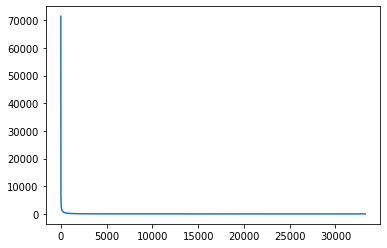

In [ ]:
# # 전체 단어 빈도 수
# sorted_cnt = sorted(word_cnt, key = word_cnt.get, reverse = True)

# w = [word_cnt[key] for key in sorted_cnt]
# plt.plot(w)
# plt.show() # 대부분 단어가 매우 적게 사용된다.

In [ ]:
# 워드 클라우드 추가하기


### Word Embedding
- TF-IDF 벡터화

In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(target['reviews'], label, test_size = 0.25, random_state = 42)

print('Train set count :', len(X_train))
print('Test set count :', len(X_test))

Train set count : 75000
Test set count : 25000


In [ ]:
# Tokenizing(13 min)
max_words = 10000
max_len = 1500 # 스크랩 데이터 보고 추후 조정

tok = Tokenizer(num_words=max_words, analyzer = twit_tokenizer) # 내가 만든 토크나이저 사용 
tok.fit_on_texts(X_train) 

sequences = tok.texts_to_sequences(X_train)

# Padding
sequences_matrix = pad_sequences(sequences, maxlen = max_len)

print('Total data : ', len(sequences_matrix), '\nPadding : ', len(sequences_matrix[0]))

Total data :  75000 
Padding :  1500


In [ ]:
# Save tokenized data(sequence)
df_seq = pd.DataFrame(sequences_matrix)

df_seq.to_csv('sequence.csv')
files.download('sequence.csv')

## Modeling

### 과제 내용을 복붙하면 어느정도 성능이 나올까
과제 모델 : Baseline
- RNN(LSTM) 모델

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from google.colab import files

In [ ]:
def RNN_Baseline():
    # Input
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 50, input_length = max_len)(inputs) 

    # LSTM
    layer = LSTM(64)(layer) 

    # Hidden layer
    layer = Dense(256, name = 'FC1')(layer) 
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)

    # Output
    layer = Dense(1, name = 'out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    
    model = Model(inputs = inputs, outputs = layer) 
    return model

In [ ]:
model = RNN_Baseline()
model.summary()
model.compile(optimizer = RMSprop(), loss = 'binary_crossentropy', metrics = ['acc']) # RMSprop() optimizer 알아보기

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1500)]            0         
                                                                 
 embedding (Embedding)       (None, 1500, 50)          500000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [ ]:
model.fit(sequences_matrix, y_train,batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 3)]) 

# Baseline 모델 저장
model.save('Sentiment_baseline.h5')

files.download('Sentiment_baseline.h5')  # from colab to browser download

Epoch 1/10
469/469 [==============================] - 47s 82ms/step - loss: 0.5325 - acc: 0.7354 - val_loss: 0.4784 - val_acc: 0.7712
Epoch 2/10
469/469 [==============================] - 39s 82ms/step - loss: 0.4867 - acc: 0.7705 - val_loss: 0.4781 - val_acc: 0.7743
Epoch 3/10
469/469 [==============================] - 41s 88ms/step - loss: 0.4530 - acc: 0.7893 - val_loss: 0.4740 - val_acc: 0.7723
Epoch 4/10
469/469 [==============================] - 39s 82ms/step - loss: 0.4294 - acc: 0.8038 - val_loss: 0.4982 - val_acc: 0.7686
Epoch 5/10
469/469 [==============================] - 37s 79ms/step - loss: 0.4137 - acc: 0.8125 - val_loss: 0.4847 - val_acc: 0.7707
Epoch 6/10
469/469 [==============================] - 37s 79ms/step - loss: 0.4184 - acc: 0.8078 - val_loss: 0.4907 - val_acc: 0.7720


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Prediction
test_sequences = tok.texts_to_sequences(X_test) # X_test도 동일하게 전처리
test_sequences_matrix = pad_sequences(test_sequences, maxlen = max_len)

print('Total data : ', len(test_sequences_matrix), '\nPadding : ', len(test_sequences_matrix[0]))

# Evaludation
accr = model.evaluate(test_sequences_matrix, y_test)

Total data :  25000 
Padding :  1500
782/782 [==============================] - 14s 18ms/step - loss: 0.5184 - acc: 0.7684


In [ ]:
print('Test set\n Loss : {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

Test set
 Loss : 0.518
 Accuracy: 0.768


정확도 약 0.77의 약간 아쉬운 성능을 보임

In [ ]:
def sentiment_predict(new_sentence):
    encoded = tok.texts_to_sequences(new_sentence)
    pad_new = pad_sequences(encoded, maxlen = max_len)

    



### CNN 모델